# Проект: Обучение с учителем: качество модели

***Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.\
\
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе.\
\
Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.***

## market_file.csv

***Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.***

1. id — номер покупателя в корпоративной базе данных.
2. Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
3. Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
4. Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
5. Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
6. Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
7. Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
8. Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
9. Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
10. Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
11. Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
12. Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
13. Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

## market_money.csv

***Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.***

1. id — номер покупателя в корпоративной базе данных.
2. Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
3. Выручка — сумма выручки за период.

## market_time.csv

***Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.***

1. id — номер покупателя в корпоративной базе данных.
2. Период — название периода, во время которого зафиксировано общее время.
3. минут — значение времени, проведённого на сайте, в минутах.

## money.csv

***Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.***

1. id — номер покупателя в корпоративной базе данных.
2. Прибыль — значение прибыли.

In [1]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from scipy import stats as st
import warnings
import shap
from sklearn.cluster import KMeans

In [3]:
warnings.filterwarnings('ignore')

# Шаг 1. Загрузка данных

In [4]:
market_file = pd.read_csv('/datasets/market_file.csv', sep=',', decimal='.')
market_money = pd.read_csv('/datasets/market_money.csv', sep=',')
market_time = pd.read_csv('/datasets/market_time.csv', sep=',')
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

In [5]:
def data_check(data):
    display(data.info())
    display(data.head(5))

In [6]:
data_check(market_file)
data_check(market_money)
data_check(market_time)
data_check(money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

None

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


***Данные в таблицах соответствуют описанию, но есть проблемы с типами данных***

# Шаг 2. Предобработка данных

In [7]:
def data_problem(data):
    display(data.isna().sum())
    display(data.duplicated().sum())

In [8]:
data_problem(market_file)

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

0

***В данных нет ни дубликатов ни пропусков, но есть проблемы с типами данных, преобразуем их***

In [9]:
columns = ['Маркет_актив_6_мес', 'Акционные_покупки']
for column in columns:
    market_file[column] = market_file[column].astype('float64')

market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

***Тип данных изменен, движемся дальше***

In [10]:
data_problem(market_money)

id         0
Период     0
Выручка    0
dtype: int64

0

***Проблем нет, изменяем тип данных***

In [11]:
market_money['Выручка'] = market_money['Выручка'].astype('float64')
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


***Идем дальше***

In [12]:
data_problem(market_time)

id        0
Период    0
минут     0
dtype: int64

0

***Проблем в данных нет, даже тип данных соответствует, Работаем дальше***

In [13]:
data_problem(money)

id         0
Прибыль    0
dtype: int64

0

***Проблем нет, идем в исследовательский анализ данных***

# Шаг 3. Исследовательский анализ данных

array([[<Axes: title={'center': 'Маркет_актив_6_мес'}>,
        <Axes: title={'center': 'Маркет_актив_тек_мес'}>,
        <Axes: title={'center': 'Длительность'}>],
       [<Axes: title={'center': 'Акционные_покупки'}>,
        <Axes: title={'center': 'Средний_просмотр_категорий_за_визит'}>,
        <Axes: title={'center': 'Неоплаченные_продукты_штук_квартал'}>],
       [<Axes: title={'center': 'Ошибка_сервиса'}>,
        <Axes: title={'center': 'Страниц_за_визит'}>, <Axes: >]],
      dtype=object)

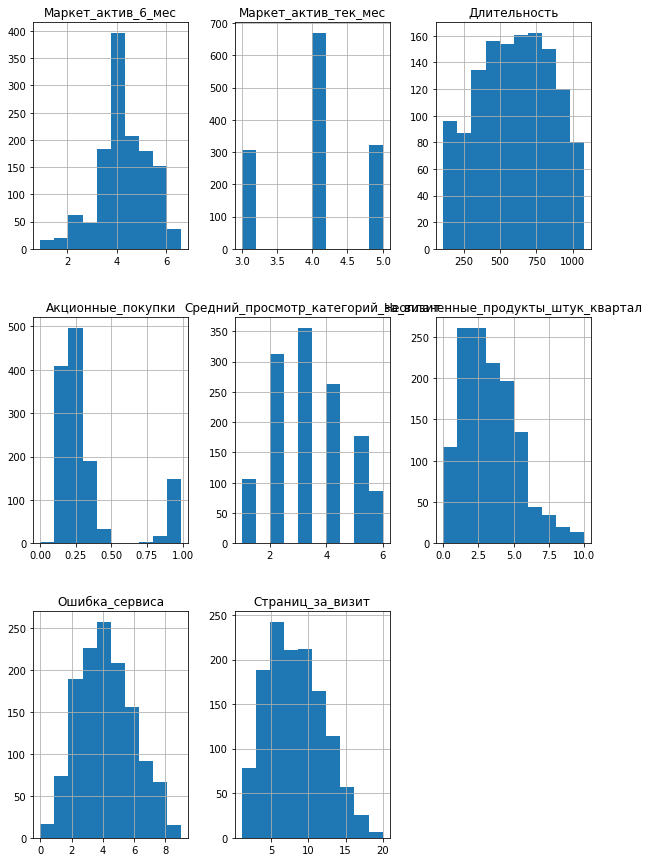

In [14]:
market_file.drop(columns=['id']).hist(figsize=(10,15))

***Распределение близкое к нормальному наблюдается на на гистограммах "Ошибка сервиса", и "Страниц за визит", на остальных графиках нормальное распределение наблюдается но более слабой форма. Заметных выбросов на графиках нет.***

<Axes: >

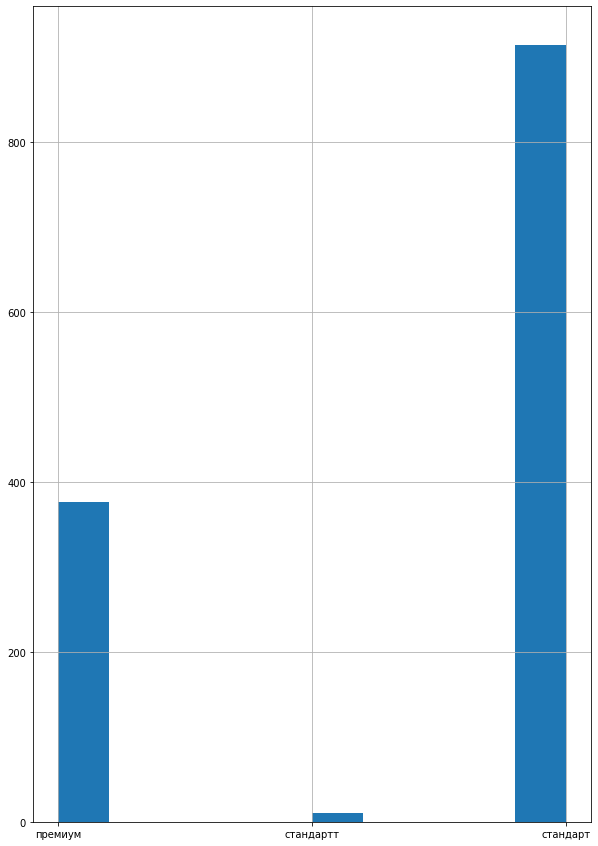

In [15]:
market_file['Тип сервиса'].hist(figsize=(10,15))

***Наибольшее количество людей пользуются сервисом без подписки***

In [16]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace(['стандартт'], 'стандарт', regex=True)

<Axes: >

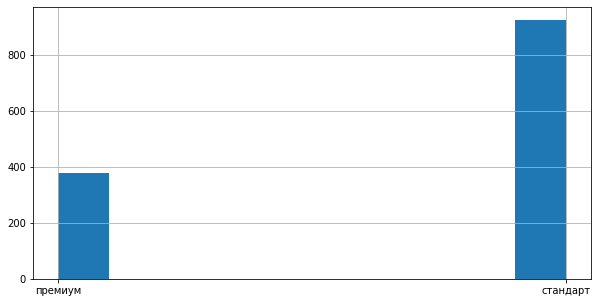

In [17]:
market_file['Тип сервиса'].hist(figsize=(10,5))

<Axes: >

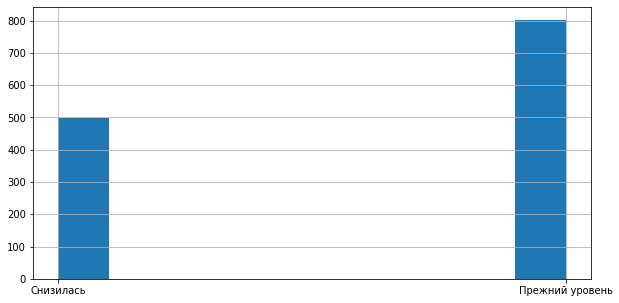

In [18]:
market_file['Покупательская активность'].hist(figsize=(10,5))

***У наибольшего числа покупателей покупательская активность осталась на прежнем уровне***

<Axes: >

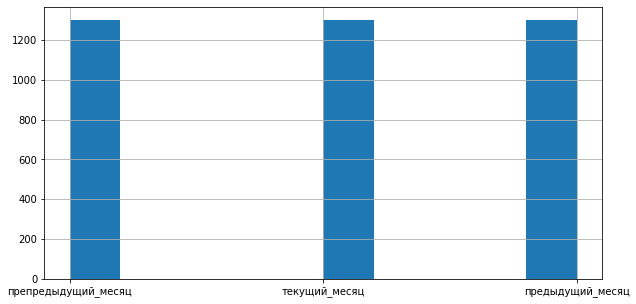

In [19]:
market_money['Период'].hist(figsize=(10,5))

***Выручка за 3 месяца распределилась равномерно по всем покупателям***

<Axes: >

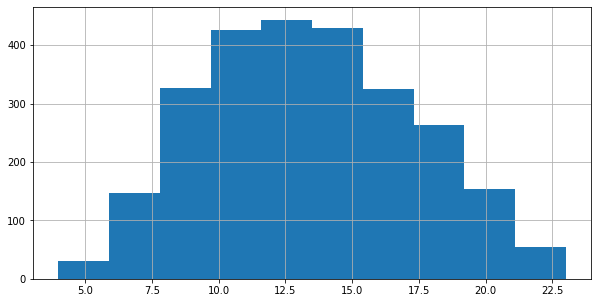

In [20]:
market_time['минут'].hist(figsize=(10,5))

***График распределения минут на сайте распределился нормально, наибольшее число пользователей проводит на сайте 12.5 не знаю чего***

<Axes: >

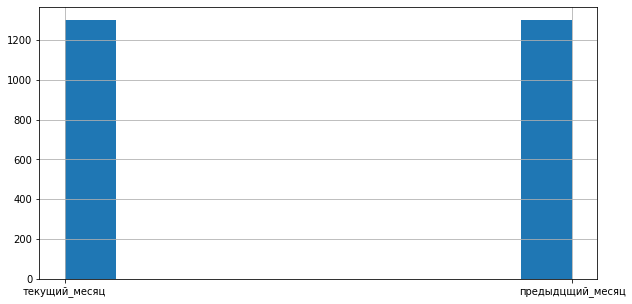

In [21]:
market_time['Период'].hist(figsize=(10,5))

***Период в который покупатели заходили на сайт распределился равномерно***

In [22]:
market_time['Период'] = market_time['Период'].replace(['предыдцщий_месяц'], 'предыдущий_месяц', regex=True)

<Axes: >

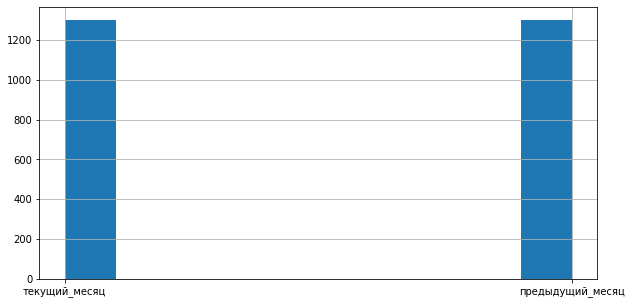

In [23]:
market_time['Период'].hist(figsize=(10,5))

<Axes: >

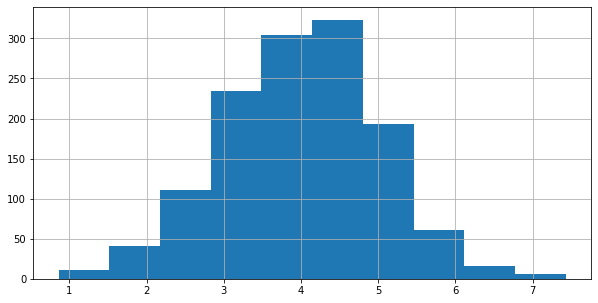

In [24]:
money['Прибыль'].hist(figsize=(10,5))

***Прибыль распределилась нормально по всем покупателям***

In [25]:
df = market_money.pivot(index='id', columns='Период', values='Выручка')
df.replace(0, np.nan, inplace=True)
df.dropna(inplace=True)
display(df)

Период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5
...,...,...,...
216643,3664.0,4704.0,4741.7
216644,4729.0,5299.0,5353.0
216645,5160.0,5334.0,5139.2


In [26]:
df_1 = pd.DataFrame(df.index.to_list(), columns=['id'])
df_1

,id
0,215349
1,215350
2,215351
3,215352
4,215353
...,...
1292,216643
1293,216644
1294,216645
1295,216646


In [27]:
filtered_market_file = market_file.loc[market_file['id'].isin(df_1['id'])] 
filtered_market_money = market_money.loc[market_money['id'].isin(df_1['id'])]
filtered_market_time = market_time.loc[market_time['id'].isin(df_1['id'])]
filtered_money = money.loc[money['id'].isin(df_1['id'])]

In [28]:
data_check(filtered_market_file)
data_check(filtered_market_money)
data_check(filtered_market_time)
data_check(filtered_money)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 1 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Покупательская активность            1297 non-null   object 
 2   Тип сервиса                          1297 non-null   object 
 3   Разрешить сообщать                   1297 non-null   object 
 4   Маркет_актив_6_мес                   1297 non-null   float64
 5   Маркет_актив_тек_мес                 1297 non-null   int64  
 6   Длительность                         1297 non-null   int64  
 7   Акционные_покупки                    1297 non-null   float64
 8   Популярная_категория                 1297 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  Ошибка_сервиса                

None

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3891 entries, 3 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3891 non-null   int64  
 1   Период   3891 non-null   object 
 2   Выручка  3891 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 121.6+ KB


None

,id,Период,Выручка
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2594 entries, 2 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2594 non-null   int64 
 1   Период  2594 non-null   object
 2   минут   2594 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 81.1+ KB


None

,id,Период,минут
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдущий_месяц,8
6,215351,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 1 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1297 non-null   int64  
 1   Прибыль  1297 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 30.4 KB


None

,id,Прибыль
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95


In [29]:
filtered_market_money.groupby('Период')['Выручка'].sum()

Период
предыдущий_месяц       6417996.5
препредыдущий_месяц    6272769.0
текущий_месяц          6895434.7
Name: Выручка, dtype: float64

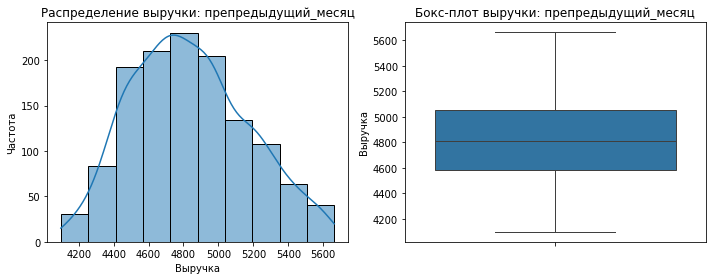

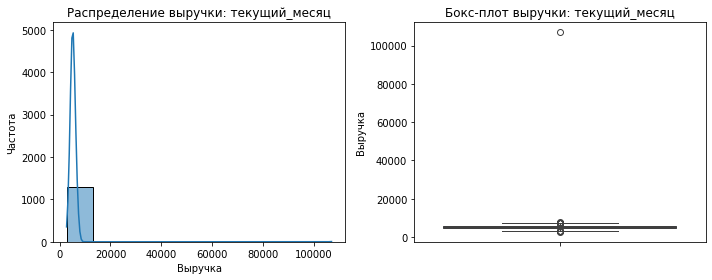

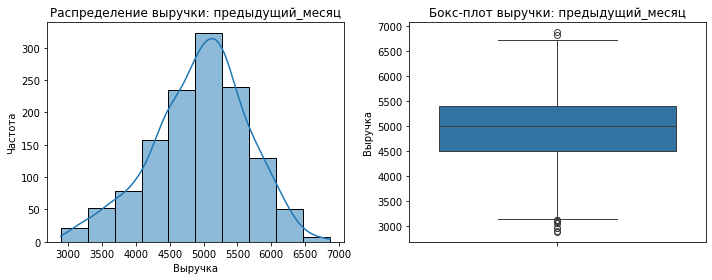

In [30]:
periods_revenue = filtered_market_money['Период'].unique()
periods_minutes = filtered_market_time['Период'].unique()

# Создание распределений для каждого периода в df_revenue
for period in periods_revenue:
    period_data_revenue = filtered_market_money[filtered_market_money['Период'] == period]

    # Выручка
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(period_data_revenue['Выручка'], kde=True, bins=10)
    plt.title(f'Распределение выручки: {period}')
    plt.xlabel('Выручка')
    plt.ylabel('Частота')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=period_data_revenue['Выручка'])
    plt.title(f'Бокс-плот выручки: {period}')
    plt.ylabel('Выручка')
    
    plt.tight_layout()
    plt.show()


In [31]:
filtered_market_money.loc[filtered_market_money['Выручка'] > 90000]

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


***Всего 1 пользователь который выбивается со своей выручкой в 100000 тысяч рублей.***

In [32]:
filtered_market_money = filtered_market_money.loc[filtered_market_money['Выручка'] < 90000]

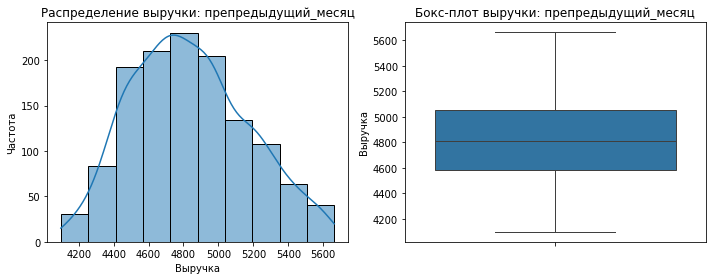

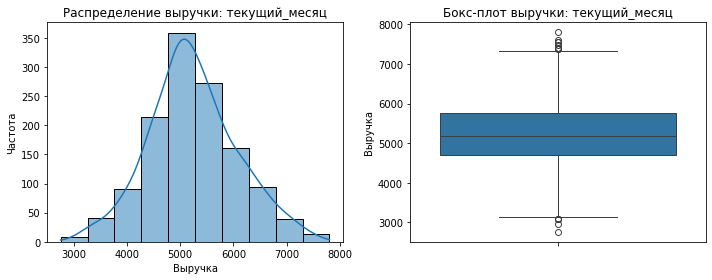

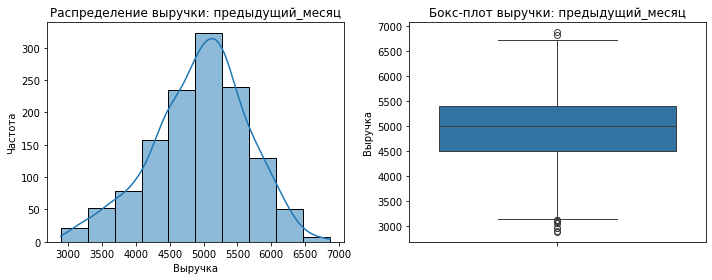

In [33]:
for period in periods_revenue:
    period_data_revenue = filtered_market_money[filtered_market_money['Период'] == period]

    # Выручка
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(period_data_revenue['Выручка'], kde=True, bins=10)
    plt.title(f'Распределение выручки: {period}')
    plt.xlabel('Выручка')
    plt.ylabel('Частота')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=period_data_revenue['Выручка'])
    plt.title(f'Бокс-плот выручки: {period}')
    plt.ylabel('Выручка')
    
    plt.tight_layout()
    plt.show()

In [34]:
filtered_market_time.groupby('Период')['минут'].sum()

Период
предыдущий_месяц    17470
текущий_месяц       17135
Name: минут, dtype: int64

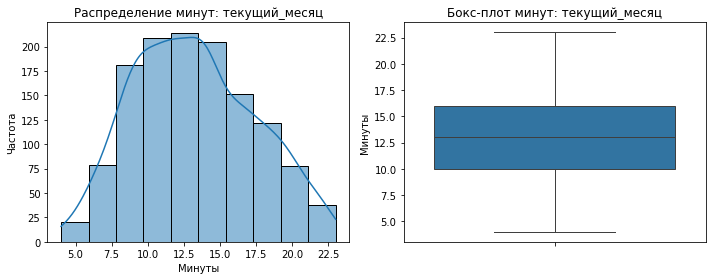

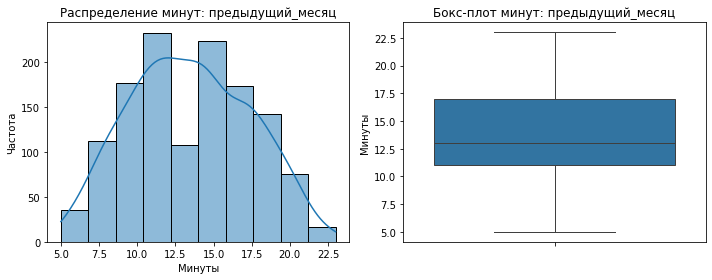

In [35]:
for period in periods_minutes:
    period_data_minutes = filtered_market_time[filtered_market_time['Период'] == period]

    # Минуты
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(period_data_minutes['минут'], kde=True, bins=10)
    plt.title(f'Распределение минут: {period}')
    plt.xlabel('Минуты')
    plt.ylabel('Частота')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=period_data_minutes['минут'])
    plt.title(f'Бокс-плот минут: {period}')
    plt.ylabel('Минуты')
    
    plt.tight_layout()
    plt.show()

***Проведен анализ данных, а также в каждом датафрейме отобраны id с покупательской активностью не менее 3 месяца. Предыдущий месяц оказался самый прибыльный, а вот текущий месяц пока что уступает двум предыдущим. ТАкже в дынных был обнаружен выброс с выручкой в 100000 тысяч в текущем месяце, видимо это какая то ошибка в данных.*** 

# Шаг 4. Объединение таблиц

In [36]:
df = filtered_market_money.pivot(index='id', columns='Период', values='Выручка')
df.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц','Выручка_текущий_месяц']
df.reset_index()

,id,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,Выручка_текущий_месяц
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5
...,...,...,...,...
1292,216643,3664.0,4704.0,4741.7
1293,216644,4729.0,5299.0,5353.0
1294,216645,5160.0,5334.0,5139.2
1295,216646,4923.0,4725.0,5224.6


In [37]:
df.isna().sum()

выручка_предыдущий_месяц       0
выручка_препредыдущий_месяц    0
Выручка_текущий_месяц          1
dtype: int64

In [38]:
df = df.fillna(0)

***Из-за удаления строчки в датафрейме появились пропуски, заполним их нулем.***

In [39]:
df_1 = filtered_market_time.pivot(index='id', columns='Период', values='минут')
df_1.columns = ['минут_предыдущий_месяц','минут_текущий_месяц']
df_1.reset_index()

,id,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,12,10
1,215350,8,13
2,215351,11,13
3,215352,8,11
4,215353,10,10
...,...,...,...
1292,216643,14,7
1293,216644,12,11
1294,216645,12,18
1295,216646,18,7


In [40]:
df_1.isna().sum()

минут_предыдущий_месяц    0
минут_текущий_месяц       0
dtype: int64

In [41]:
new_df = df.merge(df_1, on='id')
new_df.reset_index()

,id,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,Выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,5216.0,4472.0,4971.6,12,10
1,215350,5457.5,4826.0,5058.4,8,13
2,215351,6158.0,4793.0,6610.4,11,13
3,215352,5807.5,4594.0,5872.5,8,11
4,215353,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...
1292,216643,3664.0,4704.0,4741.7,14,7
1293,216644,4729.0,5299.0,5353.0,12,11
1294,216645,5160.0,5334.0,5139.2,12,18
1295,216646,4923.0,4725.0,5224.6,18,7


In [42]:
data = filtered_market_file.merge(new_df, on='id', how='left')
data

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,Выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1293,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1294,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1295,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


***Датафреймы были объеденены с добавлением новый признаков, а именно выручкой за текущиё, редыдущий и препредыдущий месяц , а также временем проведенном на сайте за текущий и предыдущий месяц***

# Шаг 5. Корреляционный анализ

,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,Выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
Маркет_актив_6_мес,1.000000,0.061697,-0.044614,-0.277968,0.185027,-0.134368,0.038656,0.319918,-0.005652,0.233325,0.004290,0.274003,0.226345
Маркет_актив_тек_мес,0.061697,1.000000,-0.131979,0.033045,-0.025158,0.061754,0.087351,0.003144,-0.027107,-0.039397,-0.011745,0.013538,-0.063044
Длительность,-0.044614,-0.131979,1.000000,0.029186,-0.043150,-0.108822,0.103528,-0.034591,0.013739,-0.039284,0.014800,-0.124000,0.083035
Акционные_покупки,-0.277968,0.033045,0.029186,1.000000,-0.203380,0.197624,-0.051590,-0.370853,0.007035,-0.267790,0.020243,-0.332743,-0.274693
Средний_просмотр_категорий_за_визит,0.185027,-0.025158,-0.043150,-0.203380,1.000000,-0.251448,0.010034,0.267536,-0.049596,0.149619,-0.070427,0.148376,0.233358
Неоплаченные_продукты_штук_квартал,-0.134368,0.061754,-0.108822,0.197624,-0.251448,1.000000,-0.098544,-0.165297,0.032958,-0.249421,0.061636,-0.183426,-0.214803
Ошибка_сервиса,0.038656,0.087351,0.103528,-0.051590,0.010034,-0.098544,1.000000,0.104508,0.035383,0.090105,0.040502,0.196017,0.078089
Страниц_за_визит,0.319918,0.003144,-0.034591,-0.370853,0.267536,-0.165297,0.104508,1.000000,-0.067879,0.311428,-0.049608,0.450913,0.298113
выручка_предыдущий_месяц,-0.005652,-0.027107,0.013739,0.007035,-0.049596,0.032958,0.035383,-0.067879,1.000000,0.308707,0.875122,-0.084632,-0.082747
выручка_препредыдущий_месяц,0.233325,-0.039397,-0.039284,-0.267790,0.149619,-0.249421,0.090105,0.311428,0.308707,1.000000,0.148569,0.348403,0.299989


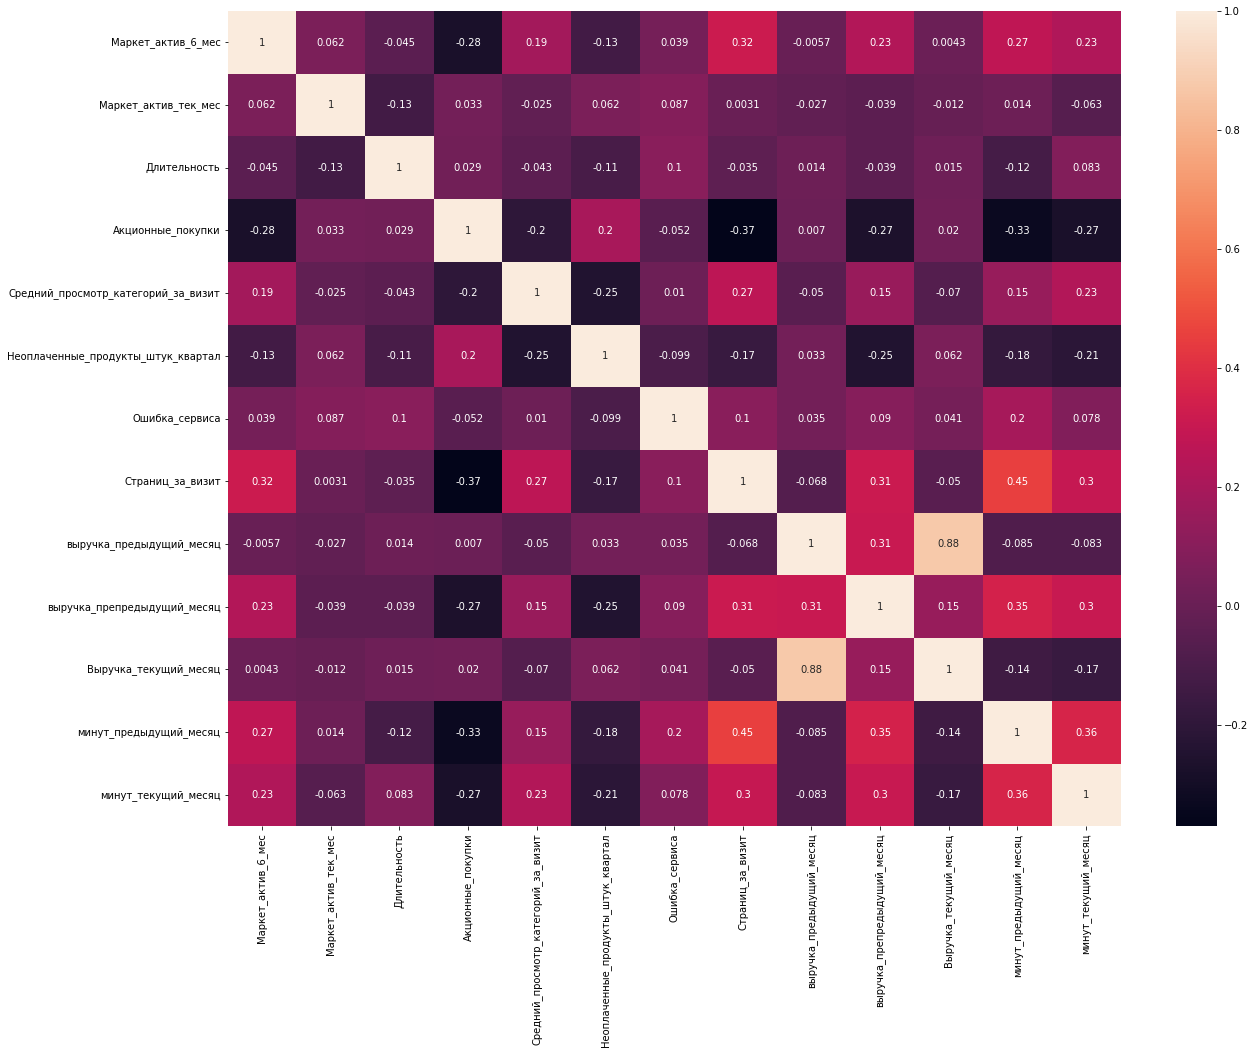

In [43]:
plt.figure(figsize=(20, 15))
sns.heatmap(data.drop('id', axis=1).corr(method='spearman'), annot=True) 
display(data.drop('id', axis=1).corr(method='spearman'))

plt.show()

***Мультиколлинеарности в данных не наблюдается, наибольшая кореляция наблюдается у выручки за предыдущий месяц с выручкой за текущий месяц***

# Шаг 6. Использование пайплайнов

In [44]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

data_1 = data.copy()

data_1['Покупательская активность'] = data_1['Покупательская активность'].apply(lambda x: 0 if x == 'Снизилась' else 1)

X = data_1.drop(columns=['Покупательская активность', 'id'])
y = data_1['Покупательская активность']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

ohe_columns = ['Популярная_категория']
ord_columns = ['Тип сервиса', 'Разрешить сообщать']
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 
               'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 
               'Ошибка_сервиса', 'Страниц_за_визит', 'выручка_предыдущий_месяц', 
               'выручка_препредыдущий_месяц', 'Выручка_текущий_месяц', 
               'минут_предыдущий_месяц', 'минут_текущий_месяц']


ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
])

ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=[
            ['премиум', 'стандарт'],
            ['да', 'нет']
        ], handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(strategy='most_frequent'))
])


data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', MinMaxScaler(), num_columns)
], remainder='passthrough')

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])


param_grid = [

    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': [0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
     {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__C': [0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)


print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

probabilities = randomized_search.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
               

***Наилучшая модель оказалась моделью SVC, на тренировочной выборке метрика показала результат 0.91, а на тестовой 0.90***  

# Шаг 7. Анализ важности признаков

  0%|          | 0/30 [00:00<?, ?it/s]

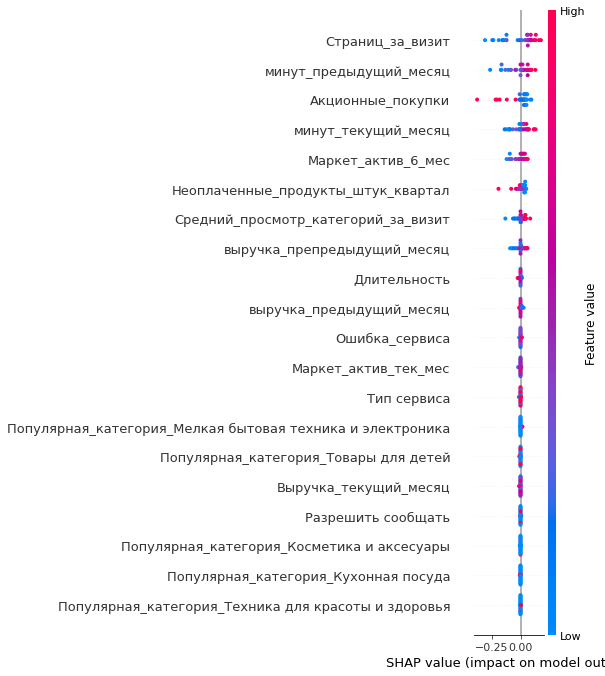

In [45]:
X_train_preprocessed = randomized_search.best_estimator_.named_steps['preprocessor'].fit_transform(X_train)
X_test_preprocessed = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test)

# Получение имен признаков
ohe_feature_names = randomized_search.best_estimator_.named_steps['preprocessor']\
                    .transformers_[0][1].named_steps['ohe'].get_feature_names(ohe_columns)
ord_feature_names = ord_columns  # OrdinalEncoder не изменяет названия признаков
num_feature_names = num_columns  # MinMaxScaler или StandardScaler не изменяют названия признаков
feature_names = list(ohe_feature_names) + list(ord_feature_names) + list(num_feature_names)

train_samples = shap.sample(X_train_preprocessed, 50)
test_samples = shap.sample(X_test_preprocessed, 30)

# Создание объекта KernelExplainer для лучшей модели
explainer = shap.KernelExplainer(randomized_search.best_estimator_.named_steps['models'].predict, train_samples)

# Рассчитываем значения SHAP для тестовых данных
shap_values = explainer.shap_values(test_samples)

# Строим summary plot
plt.figure(figsize=(30, 10))
shap.summary_plot(shap_values, features=test_samples, feature_names=feature_names, show=False)
plt.show()

***Наибольшее влияние оказывает 'Страниц за визит' он смещает прогноз в большую сторону, то есть больше влияет на 1. Наибольшее влияние на отрицательный результат оказывают 'Акционные покупки' и 'Неоплаченные покупки'.*** 

# Шаг 8. Сегментация покупателей

In [46]:
y_test_pred_1 = randomized_search.predict_proba(X)
y_test_pred_1

array([[0.97460035, 0.02539965],
       [0.37032172, 0.62967828],
       [0.8607267 , 0.1392733 ],
       ...,
       [0.05489463, 0.94510537],
       [0.10211263, 0.89788737],
       [0.51507671, 0.48492329]])

In [47]:
filtered_money['Прогноз'] = y_test_pred_1[:,0]

In [48]:
filtered_money.head()

,id,Прибыль,Прогноз
1,215349,4.16,0.974600
2,215350,3.13,0.370322
3,215351,4.87,0.860727
4,215352,4.21,0.967664
5,215353,3.95,0.745168


***Для сегментации покупателей объеденим все датафреймы в один***

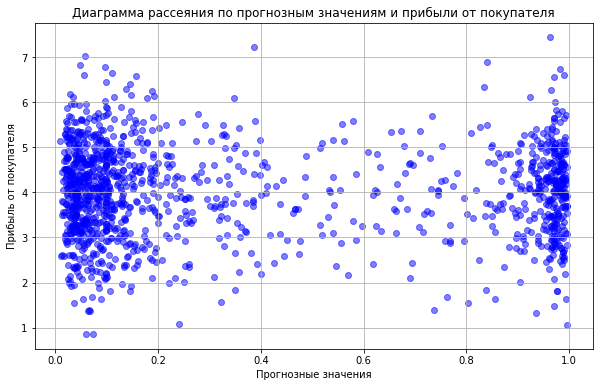

In [49]:
plt.figure(figsize=(10, 6))
plt.scatter(filtered_money['Прогноз'], filtered_money['Прибыль'], c='blue', alpha=0.5)
plt.title('Диаграмма рассеяния по прогнозным значениям и прибыли от покупателя')
plt.xlabel('Прогнозные значения')
plt.ylabel('Прибыль от покупателя')
plt.grid(True)
plt.show()

***Из диаграммы рассеяния видно, что от клиентов, которым модель присвоила класс "cнизилось", прибыль ничуть не меньше чем у клиентов, которым модель присвоила класс "прежний уровень" посмотрим, что там с группами.***

In [50]:
data_analiz = filtered_money.loc[(filtered_money['Прибыль'] > 5) & (filtered_money['Прогноз'] < 0.5)]

In [51]:
data_analiz

,id,Прибыль,Прогноз
7,215355,5.26,0.323599
328,215676,5.10,0.168925
336,215684,5.70,0.078036
342,215690,5.66,0.190267
401,215749,6.17,0.029440
...,...,...,...
1272,216620,5.25,0.132264
1281,216629,5.64,0.083488
1282,216630,6.10,0.113483
1294,216642,5.63,0.049488


***Целых 143 значения***

In [52]:
filtered_data_analiz = data.loc[data['id'].isin(data_analiz['id'])]

In [53]:
filtered_data_analiz

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,Выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
6,215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,3263.0,4749.0,3772.6,12,10
325,215676,Снизилась,стандарт,да,4.2,3,280,0.17,Домашний текстиль,1,2,3,14,5035.0,4741.0,5419.8,11,16
333,215684,Снизилась,стандарт,да,3.6,4,785,0.30,Товары для детей,2,1,3,11,6149.0,5236.0,5487.3,18,22
339,215690,Снизилась,стандарт,да,4.8,4,907,0.30,Косметика и аксесуары,2,1,1,6,5005.5,5241.0,4931.4,13,14
398,215749,Прежний уровень,премиум,да,5.8,5,624,0.30,Техника для красоты и здоровья,4,3,6,14,5190.0,4928.0,5092.5,14,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,216620,Прежний уровень,стандарт,да,6.1,4,1001,0.17,Товары для детей,3,5,6,19,5486.0,5396.0,5538.0,17,20
1278,216629,Прежний уровень,стандарт,нет,3.5,4,346,0.40,Кухонная посуда,3,1,6,7,4375.0,4786.0,4148.8,21,13
1279,216630,Прежний уровень,стандарт,да,4.4,4,488,0.29,Домашний текстиль,4,4,7,4,5322.0,4833.0,5875.8,17,16
1291,216642,Прежний уровень,премиум,да,4.2,3,991,0.40,Мелкая бытовая техника и электроника,4,3,5,12,4589.5,5011.0,4354.2,19,19


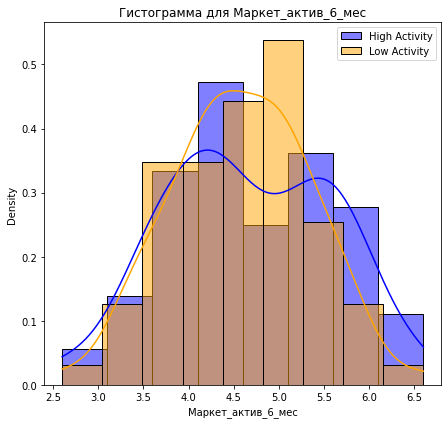

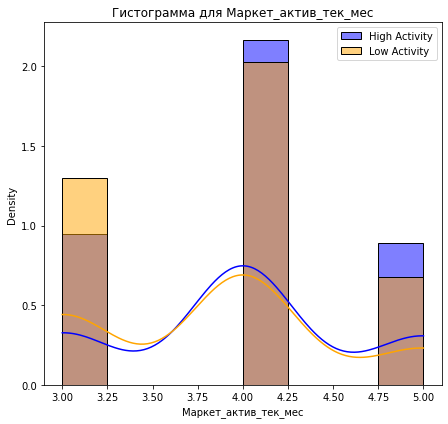

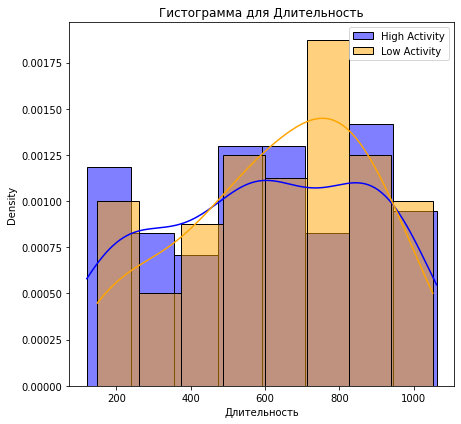

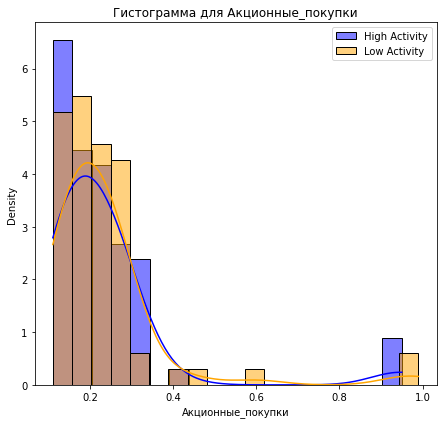

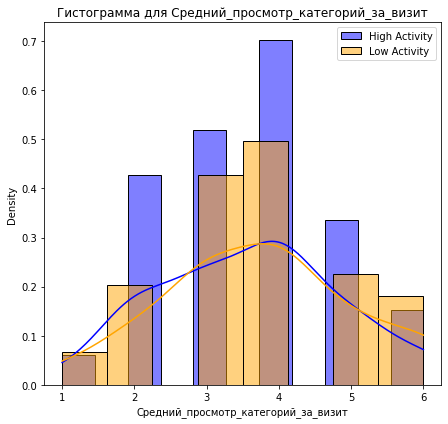

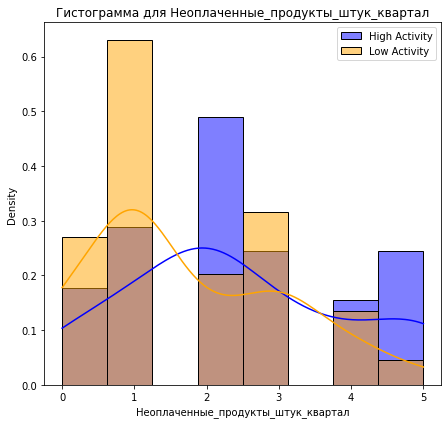

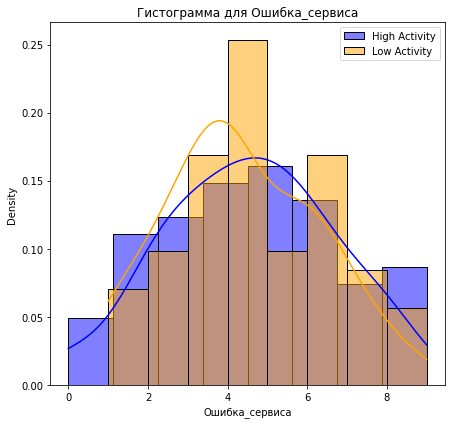

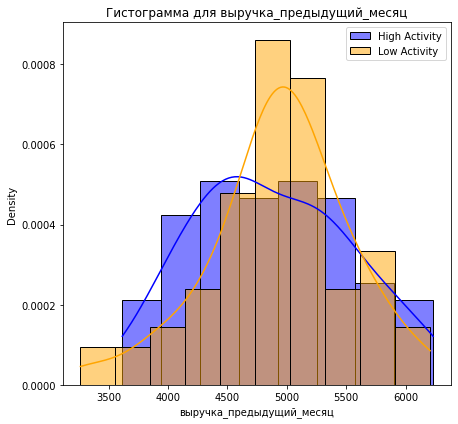

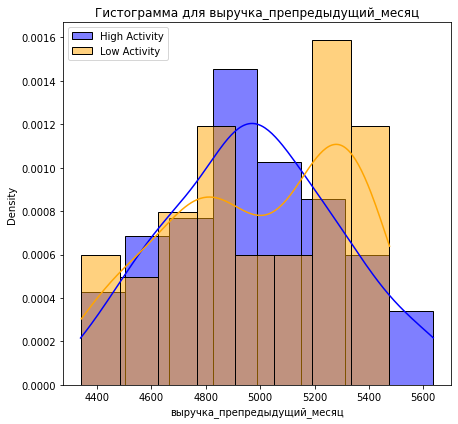

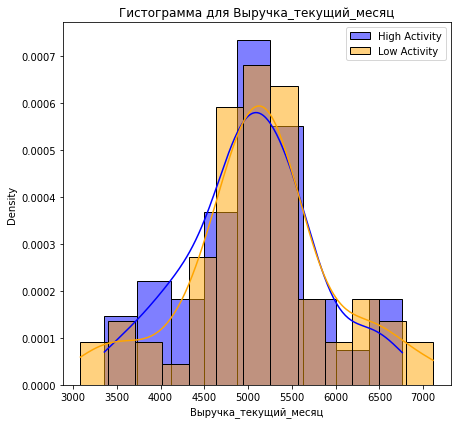

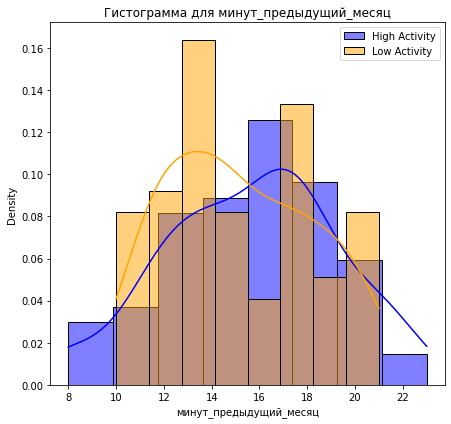

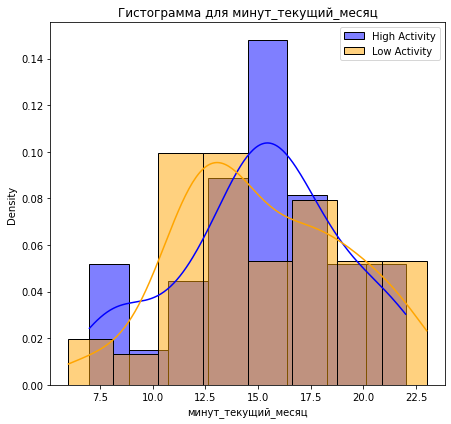

In [54]:
threshold = filtered_data_analiz['Страниц_за_визит'].mean()

# Разделяем данные на две группы
high_activity = filtered_data_analiz[filtered_data_analiz['Страниц_за_визит'] > threshold]
low_activity = filtered_data_analiz[filtered_data_analiz['Страниц_за_визит'] <= threshold]

# Список признаков для анализа
features_to_compare = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 
                       'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 
                       'Ошибка_сервиса', 'выручка_предыдущий_месяц', 
                       'выручка_препредыдущий_месяц', 'Выручка_текущий_месяц', 
                       'минут_предыдущий_месяц', 'минут_текущий_месяц']

# Построение гистограмм и бокс-плотов для каждой группы
for feature in features_to_compare:
    plt.figure(figsize=(12, 6))

    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.histplot(high_activity[feature], color='blue', label='High Activity', kde=True, stat='density')
    sns.histplot(low_activity[feature], color='orange', label='Low Activity', kde=True, stat='density')
    plt.title(f'Гистограмма для {feature}')
    plt.legend()
    plt.tight_layout()
    plt.show()

***Было***

- не привлекательный вид страниц с товарами;
- сбои в приложении на определенных спраницах;
- высокие цены на определенные тавары из просматриваемых категорий;
- конкуренция в сфере маркетплейсов (человек смотрит цену товара на этой площадке, потом переходит сравнивать в другую);
- отсутствие рекомендация на определенные товары.

# Шаг 9. Общий вывод

***В ходе предобработки данных выявилось несоответствие типов данных и ошибки в написании некоторых ячеек в столбцах. Дубликатов и пропусков в датафреймах не обнаружено.\
\
В ходе анализа данных выявлено, что выручка от покупателей за последние три месяца самой большой оказалась в предыдущем месяце (6417996), в препредыдущем месяце (6272769), в текущем месяце (6895434).\
\
Для поиска лучшей модели был написан пайплайн с перебором гиперпараметров. Перебор осуществлялся методом RandomGrid для ускорения процесса, не исключаю факт того, что при другом методе перебора лучшая модель окажется другой.\
\
Лучшейц моделью оказалась LogisticRegression с параметрами (C=1, penalty='l1', random_state=42,                                  solver='liblinear')).\
\
Из гисторнаммы распределния количества пользователей от количества страниц за визит, видно, что данные сильно "пляшут" в диапазоне от 4 до 18 стираниц. Это может быть связано с различными факторами, например:***

- не привлекательный вид страниц с товарами;
- сбои в приложении на определенных спраницах;
- высокие цены на определенные тавары из просматриваемых категорий;
- конкуренция в сфере маркетплейсов (человек смотрит цену товара на этой площадке, потом переходит сравнивать в другую);
- отсутствие рекомендация на определенные товары.